# PyTorch 과제를 시작하기 전에



우리는 PyTorch를 맛보기 위한 목적으로 공부를 하는 것이어서 깊게 들어가지 않을 거에요!

코드를 다 채우는 것이 아니므로 너무 걱정 마세요.

코드 cell의 **TODO**로 표시된 빈칸 또는 줄을 채워주시면 됩니다.

과제 파일의 길이가 길어서 찾기 힘드실 수 있을 것 같다는 생각이 들었어요.

그래서 과녁(🎯) 이모지와 함께 표시된 **문제 등장!** 을 찾아주시면 됩니다.

과녁을 잘 맞추려면 좋은 활도 필요하겠죠...? 🤔

문제를 해결하기 어려울 땐 활(🏹) 이모지와 함께 종종 등장하는 **힌트**를 참고해주세요.



그러면 이제부터 시작해 볼게요!

<br/><br/>

## PyTorch 실습 환경 🛠

이번 과제에서는 RNN을 사용하여 이미지의 label을 예측해볼 거에요.

여기서는 Tensorflow가 아니라 PyTorch를 사용하므로, 관련 모듈 또는 라이브러리가 설치되어 있어야 합니다.

Colab 환경에서는 별개의 설치 과정이 요구되지 않아서, 로컬 또는 서버에 설치하는 과정이 번거롭거나 불편하신 분들은 colab을 사용하시기를 권장드려요!

In [ ]:
# 설치가 필요하신 분들만 실행해주세요.
# conda로 가상환경 인터프리터를 사용하시는 분들은 가상환경을 activate해서 해당 가상환경에 맞게 설치해주시면 됩니다.
# (예) conda install pytorch torchvision

!pip install torch
!pip install torchvision
!pip install sklearn
!pip install numpy
!pip install pandas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Normalize, Compose, RandomHorizontalFlip, InterpolationMode, ToPILImage

<br/><br/>

## 그래픽 카드 사용하기

그래픽 카드 사용하는 것, 기억하시나요?

머신러닝, 딥러닝은 연산을 위해 많은 컴퓨팅 리소스를 요구한다고 알려져 있습니다.

이때 CPU보다는 병렬 처리에 유리한 NVIDIA 그래픽 카드를 이용하면 학습과 검증을 빠른 속도로 진행할 수 있어요.

그러기 위해서는 데이터, 모델 등을 그래픽카드에 올려놓을 수 있어야 하는데요.

아래는 이를 올려놓을 장치를 지정하기 위한 코드입니다.

## 🎯 빈칸 등장!



현재 로컬 또는 원격 컴퓨터에서 NVIDIA 그래픽 카드를 사용할 수 있는지를 확인하려면 어떻게 해야 할까요?

`torch`의 `cuda` 모듈을 사용해서 확인해 보려고 해요!

In [ ]:
# TODO 🎯 주석이 표시된 줄을 채워주세요!
device = torch.device('cuda:0' if  else 'cpu') # TODO 🎯
print ("device: %s"%(device))

device: cpu


여기서는 CPU를 사용하든 GPU를 사용하든 학습 속도가 많이 느리지 않아서 어떠한 것이든 상관 없을 것 같아요.

<br/><br/>

# <font color='#A53916'>RNN을 사용하여 이미지 분류하기</font>



<div style="background:rgb(248, 177, 178, 0.1);padding:20px;margin: 20px;color:black;">
    <b>CIFAR-10 데이터 셋</b><br/>
    이번 실습에서는 `torchvision`의 `datasets`에서 제공하는 CIFAR-10 데이터 셋을 사용할 거에요.<br/>
    CIFAR-10 데이터 세트는 클래스당 6,000개의 이미지를 포함합니다.<br/>
    10개 클래스의 60,000개 32x32 컬러 이미지로 구성되며, 교육용 이미지는 50000개, 테스트 이미지는 10000개가 있습니다.<br/>
</div>

<img src="https://paperswithcode.com/media/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg" width=50%>

<br/><br/>

## Batch란?

데이터를 모델에 입력으로 넣을 때 batch 단위로 가공하여 입력으로 넣어주는 Data Loader 기억하시나요?

이때 데이터를 얼마 만큼의 batch 단위로 잘게 썰어서 모델에게 학습시키는지 정해야 돼요.



그런데 왜 전체 데이터를 입력으로 한 번에 넣지 않고 batch 단위로 잘게 썰어 주는 것일까요?

한 번에 모든 데이터를 학습하는 것보다는 batch 단위로 학습을 진행하는 것이 리소스를 절약할 수 있어서 학습 시간을 줄일 수 있어서입니다.

음식도 한 번에 모두 먹으면 체할 수 있듯이 말이죠. 🤮



여기서는 256개의 데이터를 하나의 batch로 만들어서 학습을 진행할게요!

In [ ]:
BATCH_SIZE = 256

<br/><br/>

## Augmentation

Augmentation은 "증가"라는 뜻이죠?

무언가를 증가시킨다는 의미인 것 같은데, 왜 갑자기 이러한 개념이 나오는 걸까요?



만약에 데이터의 레이블 별로 데이터 수가 불균형하면 모델이 한쪽 이미지에만 편향되어 학습하는 경향이 생길 수 있어요.

그래서 데이터 수의 불균형을 잘 맞춰주는 게 중요합니다.

그러면 부족한 데이터를 새로 채워줘야 하는데, 그 데이터는 어디서 가져와야 할까요?



물론 새로운 데이터를 가져올 수도 있지만, 원래 있던 데이터에 변형을 주어서 새로운 이미지를 만들어낼 수도 있어요.

여기서 데이터의 변형을 이미지로 예를 들면 이미지 크기를 조정하기 무작위로 뒤집기, 색 조정하기 등 이미지 변형 방법이 있습니다.

PyTorch에서는 `torchvision`의 `transforms`에서 이미지에 변형을 가할 수 있는 함수들을 제공해줍니다.



사실 이번 과제에서는 데이터의 불균형을 맞추기 위해 실제로 부족한 레이블의 데이터 수를 늘리지는 않을 거에요.

그렇지만 augmentation을 할 때와 마찬가지로 이미지에 확률적으로 약간씩 변형을 주어서 일반화된 성능을 높이고자 해요.

또한 단순히 `torch.datasets`에서 데이터를 받아와서 사용하지 않고, 이를 Tensor로 바꿔 정규화하고자 합니다.

이를 구현한 것이 바로 아래 코드입니다.

In [ ]:
# 학습용 데이터의 이미지를 변형할 때 사용하는 클래스입니다.
class BaseAugmentation:
  # 클래스의 인스턴스가 생성될 때 실행되는 함수입니다.
  def __init__(self, mean, std, **kwargs):
    # 이미지 데이터를 어떠한 순서로 어떤 함수를 거쳐 변형할지를 정합니다.
    self.transform = Compose([
      # 50%의 확률로 수평 방향으로 뒤집어서 학습시키고자 합니다.
      RandomHorizontalFlip(0.5),
      # 이미지 픽셀의 RGB 값을 Tensor 자료형으로 바꿉니다.
      ToTensor(),
      # Tensor를 정규화하여 범위를 조정해줍니다.
      Normalize(mean=mean, std=std),
    ])

  # 생성한 인스턴스가 호출되었을 때 실행하는 함수입니다.
  def __call__(self, image):
    return self.transform(image)

<br/><br/>

## 🎯 문제 등장!

학습용 데이터의 이미지를 변형하는 클래스는 정의했는데, 테스트용 데이터 이미지 변형을 위한 클래스도 정의를 해야겠네요!

테스트용 데이터에서는 공정한 평가를 위해 이미지를 무작위로 수평으로 뒤집는 변형을 주지 않을 거에요.

이미지 픽셀의 RGB값을 Tensor로 바꾸고 이를 정규화 하는 과정은 구현하려고 하는데요.

그러면 한 번 TestAugmentation도 완성을 해볼까요?

#### 🏹 힌트

위의 BaseAugmentation에서 구현된 내용 일부만 복사해서 채워도 되겠네요!

In [ ]:
# TODO 🎯 주석이 표시된 줄을 채워주세요!

# 테스트용 데이터의 이미지를 변형할 때 사용하는 클래스입니다.
class TestAugmentation:
  # 클래스의 인스턴스가 생성될 때 실행되는 함수입니다.
  def __init__(self, mean, std, **kwargs):
    # 이미지 데이터를 어떠한 순서로 어떤 함수를 거쳐 변형할지를 정합니다.
    self.transform = Compose([
      # 이미지 픽셀의 RGB 값을 Tensor 자료형으로 바꿉니다.
      , # TODO 🎯
      # Tensor를 정규화하여 범위를 조정해줍니다.
      , # TODO 🎯
    ])
  # 생성한 인스턴스가 호출되었을 때 실행하는 함수입니다.
  def __call__(self, image):
    return self.transform(image)

<br/><br/>

#### 그런데 왜 정규화할 때 픽셀 RGB값의 평균(mean)과 분산(std)을 아래의 값처럼 정했나요? 🤔

Python에서 이미지를 정규화할 때 주로 mean을 (0.485, 0.456, 0.406), std를 (0.229, 0.224, 0.225)로 잡는데요.

ImageNet에서 사용한 평균과 분산을 그대로 쓴 것인데, 사실상 표준이자 관행이라는 말이 있네요.

자세한 내용은 [링크](https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2)를 참고해주세요.

In [ ]:
# 학습용 데이터 셋과 테스트용 데이터 셋의 이미지 데이터에 변형을 주는 객체를 생성합니다.
base_augmentation = BaseAugmentation(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
test_augmentation = TestAugmentation(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

정규화를 적용한 이미지를 다시 역정규화해서 원래 이미지처럼 보이게 하기 위한 함수이에요.

In [ ]:
denormalize = Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

<br/><br/>

## 들어가기에 앞서

앞에서 CIFAR-10은 torchtext.dataset에서 기본적으로 제공한다고 했어요.
우선 CIFAR-10 데이터 셋을 torchvision.datasets 모듈에서 가져와 볼까요?

<br/>
<br/>

`torchvision.datasets.CIFAR10()`로 우리가 필요한 데이터를 불러올 수 있어요.
마치 AG_NEWS, MNIST 데이터를 메소드 하나로 불러올 수 있는 것처럼 매우 편하죠! 😊

<br/>

이 실습에서는 필요없는 얘기일 수 있지만, 직접 수집한 일반적인 데이터는 미리 정의된 메소드가 없기 때문에 이렇게 불러올 수가 없어요.
보통 `.csv` 형식의 파일로 정리한 데이터를 `pd.read_csv()`로 불러온다고 해요.
아니면 직접 이미지, 텍스트 등 파일을 읽는 경우도 존재한다고 하네요.


## 불러온 데이터를 어디에 저장할까요?

`torchvision.datasets.CIFAR10()`의 `root` parameter를 넘겨서 가져온 데이터를 어디에 저장할지 정할 수 있어요.
필자는 현재 이 실습 코드를 실행 중인 위치의 하위 디렉토리인 `data`에 저장을 했는데요.
실습을 진행하는 여러분들이 원하시는 디렉토리에 데이터를 저장해주면 돼요!

<br/><br/>

## 🎯 문제 등장!

CIFAR10을 어느 경로의 저장할지를 정해서 빈칸에 알맞게 채워주세요.

또한, 앞서 학습용 데이터 셋과 테스트용 데이터 셋의 이미지 데이터에 변형을 주는 Augmentation 객체를 생성했던 것 기억하시나요?

각각의 데이터 셋에 `transform`이라는 파라미터를 사용해서 이미지를 변형하는 객체를 넘겨주세요.

In [ ]:
# TODO 🎯 주석이 표시된 줄을 채워주세요!

# 데이터를 저장할 디렉토리 위치를 지정해주세요.
# 변경하실 필요가 없다면 굳이 수정하지 않아도 됩니다.
DATA_DIR = './data/CIFAR10/' # TODO (Optional) 🎯

# 학습용 데이터 셋
dataset = torchvision.datasets.CIFAR10(DATA_DIR,
  transform = , download=True, train=True # TODO 🎯
)
# 테스트용 데이터 셋
test_dataset = torchvision.datasets.CIFAR10(DATA_DIR,
  transform = , download=True, train=False # TODO 🎯
)

Files already downloaded and verified
Files already downloaded and verified


<br/><br/>

불러온 학습용 데이터의 메타 정보를 한 번 확인해 볼게요.

In [ ]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/CIFAR10/
    Split: Train
    StandardTransform
Transform: <__main__.BaseAugmentation object at 0x7f87d1a88a60>

<br/><br/>

데이터의 레이블이 몇 개로 어떻게 구성되어 있는지 확인해 봅시다.

CIFAR-10 Dataset에는 멤버변수 중 `classes`로 확인할 수 있어요.

In [ ]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

<br/><br/>

## 🎯 문제 등장!

`next()`와 `iter()`로 데이터 셋의 첫 번째 요소를 직접 확인해봅시다.

#### 🏹 힌트

Python에는 iterable object라는 게 존재해요.

말 그대로 반복할 수 있는 객체라는 의미인데요.

`iter()` 메소드는 불러온 dataset을 반복할 수 있는 객체로 새로 만들겠다는 뜻이죠.

그러면 이 새로운 객체는 한 시점에 element라는 요소 하나를 반환할 수 있게 됩니다.

`next()` 메소드는 순서대로 다음 요소를 하나 불러오겠다는 의미입니다.

그래서 데이터 셋의 맨 처음 요소가 어떻게 되어있는지를 확인할 수 있죠.

In [ ]:
# TODO 🎯 주석이 표시된 줄을 채워주세요!
image, label =  # TODO 🎯
image, label

(tensor([[[-1.1075, -1.3815, -1.2617,  ...,  0.5878,  0.4851,  0.4166],
          [-1.8439, -2.1179, -1.8097,  ..., -0.0116, -0.0801, -0.0287],
          [-1.6898, -1.8439, -1.2788,  ..., -0.0972, -0.0629, -0.2513],
          ...,
          [ 1.4440,  1.3242,  1.2728,  ...,  0.6221, -1.1589, -1.2103],
          [ 0.9646,  0.8447,  1.0673,  ...,  1.0331, -0.4568, -0.6965],
          [ 0.9132,  0.7591,  0.9474,  ...,  1.5810,  0.4679, -0.0116]],
 
         [[-0.9503, -1.2304, -1.1954,  ...,  0.2752,  0.1527,  0.1352],
          [-1.6856, -2.0357, -1.8957,  ..., -0.4951, -0.5826, -0.5126],
          [-1.6155, -1.9132, -1.5630,  ..., -0.5651, -0.5651, -0.7577],
          ...,
          [ 0.9405,  0.6429,  0.7829,  ...,  0.2927, -1.4930, -1.4405],
          [ 0.3978,  0.1176,  0.4853,  ...,  0.5553, -0.9503, -1.1078],
          [ 0.4853,  0.2227,  0.4503,  ...,  1.1856,  0.0301, -0.4251]],
 
         [[-0.7064, -1.0201, -1.0550,  ...,  0.0779, -0.0267, -0.0092],
          [-1.4559, -1.8044,

<br/><br/>

가져온 이미지의 크기를 확인해 볼게요.

In [ ]:
image.shape

torch.Size([3, 32, 32])

<br/><br/>

## 🎯 문제 등장!

현재 확인한 이미지는 정규화가 되어 있어서 가공 없이 이미지를 출력해 버리면 색이 이상하게 나올 거에요.

앞에서 이미지 픽셀 RGB 값을 역정규화하는 `denormalize` 함수를 정의했던 것 기억하시나요?

여기서 역정규화를 해서 원래에 가까운 이미지를 확인할 수 있도록 해 봐요.

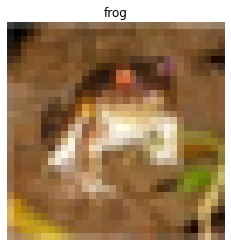

In [ ]:
# TODO 🎯 주석이 표시된 줄을 채워주세요!
plt.imshow(ToPILImage()(  )) # TODO 🎯
plt.title(f"{dataset.classes[label]}")
plt.axis('off')
plt.show()

<br/><br/>

## 🎯 문제 등장! (... 😅)

학습용 데이터를 진짜로 학습할 데이터와 검증용으로 사용할 데이터로 나누려고 해요.

`torch.utils.data`의 `random_split` 메소드를 사용하려면 어떻게 코드를 작성해야 할까요?

#### 🏹 힌트

실습 시간에 직접 만들었던 Custom Dataset의 `split_dataset`의 구현 내용을 참고하세요!

In [ ]:
# TODO 🎯 주석이 표시된 줄을 채워주세요!

# PyTorch에서 랜덤으로 설정되는 값을 고정하기 위해 사용합니다.
torch.manual_seed(43)

val_ratio = 0.2
data_size = len(dataset)

# 전체 데이터 크기에서 비율만큼만 검정용 데이터 셋의 크기로 설정하려고 합니다.
val_set_size =  # TODO 🎯

# 학습용 데이터 셋의 크기는 전체 데이터 셋의 크기에서 검증용 데이터 셋의 크기를 빼서 구합니다.
train_set_size =  # TODO 🎯

# random_split 메소드를 사용해서 dataset을 위에서 설정한 학습용 데이터 셋 크기와 검정용 데이터 셋 크기로 분할합니다.
train_dataset, val_dataset = random_split(dataset, [train_set_size, val_set_size])

<br/><br/>

## 🎯 문제 등장! (... 🙁)

`DataLoader`로 학습용, 검정용, 테스트용 데이터 셋의 Data Loader를 생성할게요.

파라미터를 알맞게 채워주세요.


In [ ]:
# TODO 🎯 주석이 표시된 줄을 채워주세요!

train_dataloader = DataLoader( , batch_size=BATCH_SIZE, shuffle=True) # TODO 🎯
val_dataloader = DataLoader( , batch_size=BATCH_SIZE, shuffle=False) # TODO 🎯
test_dataloader = DataLoader( , batch_size=BATCH_SIZE, shuffle=False) # TODO 🎯

<br/><br/>

## 🎯 문제 등장! (... 😡)

`next()`와 `iter()`로 데이터 셋의 첫 번째 요소를 직접 확인해봅시다.

In [ ]:
# TODO 🎯 주석이 표시된 줄을 채워주세요!
images, labels =  # TODO 🎯

<br/><br/>

## 🎯 문제 등장! (... 😇)

현재 확인한 이미지는 정규화가 되어 있어서 가공 없이 이미지를 출력해 버리면 색이 이상하게 나올 거에요.

앞에서 이미지 픽셀 RGB 값을 역정규화하는 `denormalize` 함수를 정의했던 것 기억하시나요?

여기서 역정규화를 해서 4×4 서브 플롯으로 16개의 원래에 가까운 이미지와 레이블을 확인해 봅시다.

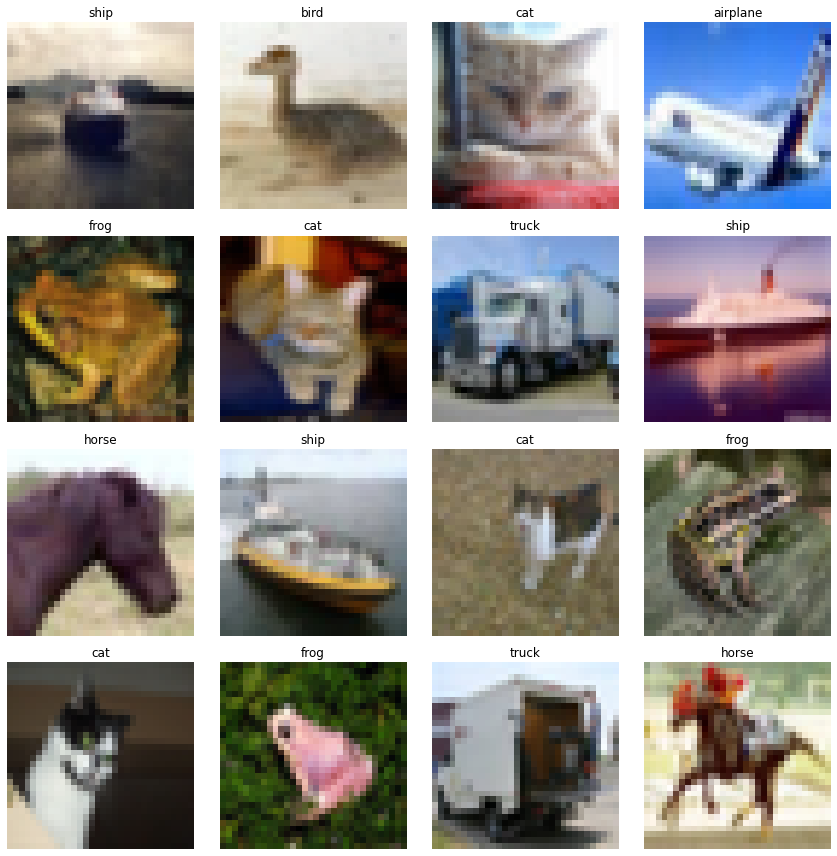

In [ ]:
# TODO 🎯 주석이 표시된 줄을 채워주세요!
plt.figure(figsize=(12,12))
for n, (image, label) in enumerate(zip(images, labels), start=1):
    plt.subplot( , ,n) # TODO 🎯
    plt.imshow(ToPILImage()(  )) # TODO 🎯
    plt.title(f"{dataset.classes[label]}")
    plt.axis('off')
    if n >= : # TODO 🎯
      break
plt.tight_layout()
plt.show()

<br/><br/>

# Model 제작하기

> PyTorch에서는 상대적으로 자신이 직접 모델을 수정할 수 있는 자유도가 높아요.
> 이 과제에서도 직접 모델을 만들면서 DIY를 실천해보도록 해요!


<br/><br/>

## 🎯 문제 등장!

이미지를 어떻게 RNN으로 학습한다는 건지 잘 감이 안 잡히는 것 같아요... 😭

그런데 잘 생각해보면 이미지는 가로 길이만큼의 여러 개의 픽셀이 한 줄을 이룹니다.

그리고 이 줄이 세로로 여러 개 모여 하나의 이미지를 이루는 것이죠.

그러면 이미지를 세로로 보면서 한 줄씩 읽으면 RNN으로 학습할 수 있는 순차 데이터가 될 수 있지 않을까요?

우리가 개구리라는 사진을 볼 때는 이미지의 일부분의 특징을 바로 한 번에 봐서 해당 이미지의 대상이 개구리임을 파악을 하죠.

하지만 AI 모델을 RNN으로 만들면 이미지의 위에서부터 세로로 한 줄씩 위에서 아래로 해석하는 것과 같습니다.



이미지의 **세로 길이**를 **RNN의 시퀀스 길이**, 즉 RNN에서 통과할 cell의 수로 정해 봅시다.

그러면 이미지의 **가로 길이**는 **RNN의 입력 차원**이 되겠네요.

이를 잘 생각해서 `CustomRNN` 모델의 입력 차원을 설정해볼까요?

#### 🏹 힌트

우리가 학습하는 데이터는 32×32 크기의 이미지라고 했는데요.

그러면 가로 길이와 세로 길이 모두 32이겠네요.

가로 길이가 입력 차원이라고 했는데, 한 가지 놓치지 말아야 될 부분이 있어요.

한 픽셀 당 RGB이 존재해서 총 3개의 값이 존재한다는 사실을요.

그러면 가로 길이 32에다가 3을... 어떻게 해야할까요? 🤔



다른 부분은 실습 시간에 직접 만들었던 `TextClassifier` 모델의 RNN 레이어를 참고해보세요.

In [ ]:
# TODO 🎯 주석이 표시된 줄을 채워주세요!

# 모델 클래스를 정의할 때 무엇을 상속받아야 될까요?
class CustomRNN(  ): # TODO 🎯
  # input_dim: 이미지의 한 줄의 데이터에 대한 vector의 차원입니다.
  # hidden_dim: RNN의 hidden state의 차원입니다.
  # num_layers = RNN을 몇 단만큼 쌓을지를 정합니다.

  # CustomRNN 클래스의 인스턴스를 생성할 때 자동으로 호출되는 함수입니다.
  def __init__(self, input_dim, hidden_dim, num_classes, num_layers = 3):
    super().__init__()

    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.num_classes = num_classes
    self.num_layers = num_layers

    # RNN 레이어는 기본적으로 입력 차원, hidden state 차원, 쌓을 RNN의 수 등을 파라미터로 넘깁니다.
    self.rnn = nn.RNN(  ,  ,  , batch_first=True) # TODO 🎯

    # 10개의 라벨 중 하나로 예측해야 하므로 차원을 바꾸기 위해 선형 변환하는 레이어를 설정합니다.
    self.linear = nn.Linear(self.hidden_dim, ) # TODO 🎯


  # 모델에 데이터를 파라미터로 넘겨서 실행하면 자동적으로 모델의 `forward` 함수가 호출됩니다.
  def forward(self, x):
    # 처음 RNN에 들어갈 hidden state를 0으로 초기화하는 작업입니다.
    # 참고로 RNN의 hidden state의 차원은 [num_layers, batch_size, hidden_dim]입니다.
    hidden_state = torch.zeros(
        , x.size(0),    # TODO 🎯
    ).to(device)
    rnn_out, hidden_state = self.rnn(x, hidden_state)

    # RNN의 최종 결과에서 각 batch_size별로 마지막 cell에서 나온 hidden state의 결과를 가지고 선형 변환을 하여 레이블 수만큼의 차원으로 변환합니다.
    out = self.linear(  ).view([-1,   ]) # TODO 🎯
    return out

In [ ]:
# TODO 🎯 주석이 표시된 줄을 채워주세요!

# RNN의 입력 차원(input_dim)과 모델의 최종 출력 차원(num_classes)을 어떻게 설정해줘야 할까요?
input_dim =  # TODO 🎯
num_classes =  # TODO 🎯

# 학습하는 이미지의 세로 길이를 저장해주세요.
HEIGHT =  # TODO 🎯

model = CustomRNN(input_dim=input_dim, hidden_dim=256, num_classes=num_classes, num_layers = 3)

<br/><br/>

# Loss와 Optimizer 설정



Loss 함수는 실제 레이블과 모델이 예측한 값의 차이를 어떤 식으로 정의할지를 결정하는 것입니다.

그리고 Optimizer는 back propagation 적용 후 모델의 파라미터를 어떻게 업데이트할지 그 방식을 결정하는 것이죠.


## 🎯 문제 등장!

이번 과제에서는 10개의 레이블로 분류하는 것이므로 cross entropy loss 함수와 Adam 적용해보겠습니다.

#### 🏹 힌트

 `torch.nn`에서 기본적으로 제공하는 loss 함수와 `torch.optim`에서 제공하는 optimizer에서 원하는 것들을 가져올 수 있습니다.

In [ ]:
# TODO 🎯 주석이 표시된 줄을 채워주세요!

criterion =  # TODO 🎯
# Optimizer의 Learning Rate은 0.001로 설정해주세요.
optimizer =  # TODO 🎯
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.5)

이 부분은 데이터를 학습할 때 차원이 어떻게 변하는지를 시험해보는 코드입니다.

각 레이어와 입력, 차원의 결과가 어떻게 나타나는지를 확인해 봅시다.

In [ ]:
x_numpy = np.random.rand(BATCH_SIZE, HEIGHT, input_dim)
x_torch = torch.from_numpy(x_numpy).float().to(device)
rnn_out, hidden_state = model.rnn(x_torch)

print("rnn_out:",rnn_out.shape)
print("Hidden State hn:", hidden_state.shape)
print("Transformed rnn_out:", rnn_out[:, -1:].shape)

rnn_out: torch.Size([256, 32, 256])
Hidden State hn: torch.Size([3, 256, 256])
Transformed rnn_out: torch.Size([256, 1, 256])


<br/><br/>

# 검증 과정



검증 DataLoader의 batch마다 모델에 입력을 넣어서 나오는 예측 레이블을 실제 레이블과 비교해야 합니다.

검증 결과의 정확도와 F1 score를 구해서 반환하는 함수를 구현해봅시다.

## 🎯 문제 등장!

다음 조건을 만족하도록 검증 과정을 완성해주세요.

1. 검증 전 과정에서 자동 미분을 비활성해 주세요.
2. 모델을 train 모드가 아닌 eval 모드로 설정해주세요.
3. 검증 함수의 입력으로 받은 Data Loader를 가지고 학습을 진행해주세요.
4. 모델에 입력을 넣었을 때 반환한 값 리스트에서 가장 높은 값의 인덱스를 구해주세요.
5. 실제 레이블과 예측 레이블이 같은 것의 개수를 `val_correct`에 더해 주세요.

#### 🏹 힌트

`torch.no_grad()` 함수를 써서 모델의 파라미터가 자동미분되지 않도록 해줄 수 있습니다.

그런데 어차피 loss 함수의 backward()를 실행하지 않으면 back propagation이 실행되지 않을 텐데 상관이 없지 않을까요?

맞습니다! 사실 주된 목적은 자동 미분을 비활성화해서 메모리 사용량을 줄이고 연산의 효율성을 높이기 위한 것입니다.

컴퓨팅 리소스는 아끼면 아낄수록 좋은 것이니까요.

In [ ]:
# TODO 🎯 주석이 표시된 줄을 채워주세요!

def validate(model, dataloader):
  # 1. 자동 미분 기능을 끔으로써 연산과 메모리 사용의 효율성을 높여줍니다.
  with   : # TODO 🎯

    # 2. 모델(model)을 train 모드가 아닌 eval 모드로 설정해주세요.
      # TODO 🎯

    val_count = 0
    val_correct = 0

    val_labels = []
    val_predicts = []

    # 3. 검증 함수의 입력으로 받은 Data Loader를 가지고 학습을 진행해주세요.
    for index, (inputs, labels) in enumerate(  ): # TODO 🎯
      inputs = inputs.view(-1, HEIGHT, input_dim)
      inputs = inputs.to(device)
      labels = labels.to(device)

      # 4. 모델에 입력을 넣었을 때 반환한 값 리스트에서 가장 높은 값의 인덱스를 구해주세요.
      outs = model(inputs)
      predicts =  # TODO 🎯

      val_labels.append(labels.cpu())
      val_predicts.append(predicts.cpu())

      # 5. 실제 레이블과 예측 레이블이 같은 것의 개수를 `val_correct`에 더해 주세요.
      val_correct += (  ).sum().item() # TODO 🎯
      val_count += inputs.size(0)

    val_acc = (val_correct / val_count)

    val_labels = np.concatenate(val_labels)
    val_predicts = np.concatenate(val_predicts)
    val_f1_score = f1_score(val_labels, val_predicts, average='macro')

  return val_acc, val_f1_score

아직 학습을 진행하지 않고 모델을 검증했을 때는 정확도가 약 0.1에 가까운 수치를 보이네요.

10개의 레이블에서 1개를 무작위로 뽑을 확률인 10%와 유사함을 알 수 있습니다.

In [ ]:
train_acc, train_f1_score = validate(model, train_dataloader)
print (f"default acc: {train_acc} / default f1 score: {train_f1_score}")

default acc: 0.099425 / default f1 score: 0.05748333771762121


<br/><br/>

# 학습 과정

앞에서 우리가 정한 `DataLoader`로 전체 데이터를 batch 별로 하나씩 가져와 학습시키도록 하면 됩니다.

## 🎯 문제 등장!

Batch 별로 학습을 진행하는 구체적인 과정을 따라서 학습 과정을 완성해주세요.

1. 학습 함수(`train()`)의 입력으로 받은 Data Loader를 가지고 학습을 진행해주세요.
2. Optimizer의 `zero_grad()` 함수로 optimizer에 있는 파라미터를 모두 0으로 초기화해주세요.
3. 모델에 입력을 넣었을 때 반환한 값 리스트에서 가장 높은 값의 인덱스를 구해주세요.
4. 앞에서 정한 loss 함수로 실제 레이블과 모들이 예측한 값의 차이를 구해주세요.
5. Loss 함수의 `backward()` 함수로 back propagation을 진행하여 각 파라미터의 gradient를 구하세요.
6. Optimizer의 `step()` 함수로 4번에서 구한 gradient를 가지고 모델의 각 파라미터를 업데이트해주세요.
7.  실제 레이블과 예측 레이블이 같은 것의 개수를 `train_acc`에 더해 주세요.

In [ ]:
# TODO 🎯 주석이 표시된 줄을 채워주세요!

def train(model, dataloader, epoch):
  model.train()

  train_acc = 0
  train_count = 0
  log_interval = 30

  # 1. 학습 함수(`train()`)의 입력으로 받은 Data Loader를 가지고 학습을 진행해주세요.
  for index, (inputs, labels) in enumerate(dataloader): # TODO 🎯

    # 2. Optimizer의 `zero_grad()` 함수로 optimizer에 있는 파라미터를 모두 0으로 초기화해주세요.
     # TODO 🎯

    inputs = inputs.view(-1, 32, 96)
    inputs = inputs.to(device)
    labels = labels.to(device)

    # 3. 모델에 입력을 넣었을 때 반환한 값 리스트에서 가장 높은 값의 인덱스를 구해주세요.
    outs = model(inputs)
    predicts = torch.argmax(outs, dim=-1) # TODO 🎯

    # 4. 앞에서 정한 loss 함수로 실제 레이블과 모들이 예측한 값의 차이를 구해주세요.
    loss =  # TODO 🎯

    # 5. Loss 함수의 `backward()` 함수로 back propagation을 진행하여 각 파라미터의 gradient를 구하세요.
     # TODO 🎯

    # 6. Optimizer의 `step()` 함수로 4번에서 구한 gradient를 가지고 모델의 각 파라미터를 업데이트해주세요.
     # TODO 🎯

    # 7. 실제 레이블과 예측 레이블이 같은 것의 개수를 `train_acc`에 더해 주세요.
    train_acc += (  ).sum().item() # TODO 🎯
    train_count += labels.size(0)


    if index % log_interval == 0 and index > 0:
      print(f"| epoch {epoch:3d} | {index:5d}/{len(dataloader):5d} batches | accuracy {train_acc / train_count:8.3f}")

  scheduler.step()

<br/><br/>

이제 마지막으로 epoch 수만큼 학습과 검증을 반복해주면 됩니다.

## 🎯 문제 등장!

Epoch 별로 검증 시 가장 f1 score가 높게 나온 시점의 모델의 파라미터를 저장해주세요.

#### 🏹 힌트

`torch.save(model, PATH)`로 모델 그 자체, 또는 `torch.save(model.state_dict(), PATH)`로 모델의 파라미터를 저장할 수 있습니다.
여기서 저장되는 모델 또는 모델의 파라미터의 확장자는 `.pt`입니다.

In [ ]:
# TODO 🎯 주석이 표시된 줄을 채워주세요!

epochs = 5
best_acc = 0
best_f1 = 0
for epoch in range(1, epochs + 1):
  train(model, train_dataloader, epoch)
  acc_val, f1_val = validate(model, val_dataloader)

  print('-' * 70)
  if best_acc < acc_val:
    best_acc = acc_val

  if best_f1 < f1_val:
    best_f1 = f1_val
    print(f"| best score!! | best accuracy {best_acc:8.3f} | best f1 score {best_f1:8.3f}")
    torch.save(  , f"{DATA_DIR}/best.pth") # TODO 🎯
  
  print(f"| end of epoch {epoch:3d} | best accuracy {acc_val:8.3f} | best f1 score {f1_val:8.3f}")
  
  print('-' * 70)

| epoch   1 |    30/  157 batches | accuracy    0.256
| epoch   1 |    60/  157 batches | accuracy    0.280
| epoch   1 |    90/  157 batches | accuracy    0.292
| epoch   1 |   120/  157 batches | accuracy    0.301
| epoch   1 |   150/  157 batches | accuracy    0.312
----------------------------------------------------------------------
| best score!! | best accuracy    0.361 | best f1 score    0.347
| end of epoch   1 | best accuracy    0.361 | best f1 score    0.347
----------------------------------------------------------------------
| epoch   2 |    30/  157 batches | accuracy    0.370
| epoch   2 |    60/  157 batches | accuracy    0.375
| epoch   2 |    90/  157 batches | accuracy    0.382
| epoch   2 |   120/  157 batches | accuracy    0.384
| epoch   2 |   150/  157 batches | accuracy    0.387
----------------------------------------------------------------------
| best score!! | best accuracy    0.425 | best f1 score    0.409
| end of epoch   2 | best accuracy    0.425 | be

## 축하드려요! 🥳 드디어 끝이 났네요.

PyTorch에 능숙하신 분도 계실 거고 좀 낯선 분들도 계셨을 텐데 그래도 쉽지 않은 내용 따라와주셔서 감사합니다!
내용도 길고 대화체로 설명하는 오글거리는 말투 때문에 많이 고통스러우셨을 텐데... 😅 정말 고생 많으셨습니다! 🤗